## Analysis of Tree-Based Methods on the APS Failure dataset using SMOTE

In this project , I have studied SMOTE (Synthetic Minority Over-sampling Technique) and trained a Logistic Model Tree using the
pre-processed data for classification of data on the APS Failure dataset.

The dataset used is  APS Failure dataset from : https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks. 

The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

The dataset consists of data collected from heavy Scania 
trucks in everyday usage. The system in focus is the 
Air Pressure system (APS) which generates pressurised 
air that are utilized in various functions in a truck, 
such as braking and gear changes. The datasets' 
positive class consists of component failures 
for a specific component of the APS system. 
The negative class consists of trucks with failures 
for components not related to the APS. The data consists 
of a subset of all available data, selected by experts. 

### Using SMOTE (Synthetic Minority Over-sampling Technique) to pre-process data to compensate for class imbalance.

In [1]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Loading the DATA
aps_train_smote = pd.read_csv('new_train.csv')

# initialising SMOTE
smote = SMOTE(random_state=0,ratio=1)

# Dividing the data into X and Y
aps_train_x=aps_train_smote.drop('class',axis=1)
aps_train_y=aps_train_smote['class']

#Fit SMOTE and BALANCE CLASSES

smote_fit = smote.fit_sample(aps_train_x,aps_train_y)
X_smote= pd.DataFrame(smote_fit[0])
Y_smote= pd.DataFrame(smote_fit[1],columns=['class'])
aps_train_smote = pd.concat([X_smote,Y_smote],axis=1)

In [2]:
print("After Balancing : \n",aps_train_smote['class'].value_counts())

After Balancing : 
 pos    59000
neg    59000
Name: class, dtype: int64


In [3]:
import weka.core.jvm as jvm 
jvm.start()
import weka.core.converters as convert

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['C:\\ProgramData\\Anaconda3\\lib\\site-packages\\javabridge\\jars\\rhino-1.7R4.jar', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\javabridge\\jars\\runnablequeue.jar', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\javabridge\\jars\\cpython.jar', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\weka\\lib\\python-weka-wrapper.jar', 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\weka\\lib\\weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled
DEBUG:javabridge.jutil:Creating JVM object
DEBUG:javabridge.jutil:Signalling caller


In [4]:
aps_train_smote.to_csv('aps_train_smote.csv',sep=',',index=False)
aps_train = convert.load_any_file(filename='aps_train_smote.csv')
aps_train.class_is_last()

### Doing 5-Fold Cross Validation with Balanced Data

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from weka.classifiers import Classifier
from weka.classifiers import Evaluation
from weka.core.classes import Random
import weka.plot.classifiers as plcls

DEBUG:matplotlib:CACHEDIR=C:\Users\ssaya\.matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from C:\Users\ssaya\.matplotlib\fontList.json
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [6]:
smote_cls = Classifier(classname="weka.classifiers.trees.LMT")
tr_smote_eval = Evaluation(aps_train)
tr_smote_eval.crossvalidate_model(classifier=smote_cls,data=aps_train,num_folds=5,rnd=Random(0))

### Train Error  and Confusion Matrix after cross validation 

In [7]:
print("Train CV Error = %.2f%%" % (tr_smote_eval.percent_incorrect))
print(tr_smote_eval.matrix())

Train CV Error = 1.46%
=== Confusion Matrix ===

     a     b   <-- classified as
 58127   873 |     a = neg
   844 58156 |     b = pos



### Evaluating the model on train set

In [8]:
smote_cls1 = Classifier.make_copy(smote_cls)
smote_cls1.build_classifier(aps_train)
predict_y = tr_smote_eval.test_model(smote_cls1,aps_train)

In [9]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import metrics

In [15]:
y_true = np.array(np.where(aps_train_smote['class']=='neg',0,1))

### ROC Curve for Training Data

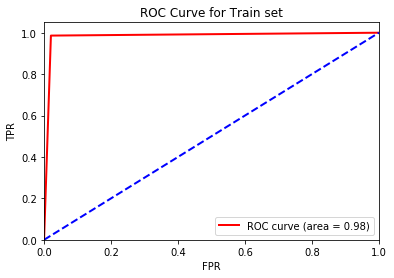

In [29]:
fpr, tpr, _ = roc_curve(y_true,predict_y)
plt.figure()
plt.plot(fpr, tpr, color='red',lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Train set')
plt.legend(loc="lower right")
plt.show()

### Evaluating and Testing the Model on Test data

In [18]:
aps_test = convert.load_any_file(filename='new_test.csv')

In [19]:
aps_test.class_is_last()

In [20]:
ts_eval=Evaluation(aps_test)
test_pred_y=ts_eval.test_model(smote_cls1,aps_test)

### Test Error  and Confusion Matrix on test set

In [21]:
print("Test Error for SMOTE = %.2f%%" % (ts_eval.percent_incorrect))
print(ts_eval.matrix())

Test Error for SMOTE = 2.39%
=== Confusion Matrix ===

     a     b   <-- classified as
 15287   338 |     a = neg
    45   330 |     b = pos



### ROC for Test Set

In [22]:
aps_test1= pd.read_csv('new_test.csv')
y_test_true=np.array(np.where(aps_test1['class']=='neg',0,1))

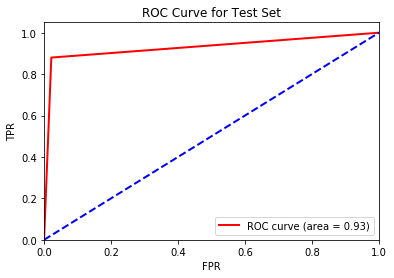

In [31]:
fpr, tpr, _ = roc_curve(y_test_true,test_pred_y)
plt.figure()
plt.plot(fpr, tpr, color='red',lw=2, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve for Test Set')
plt.legend(loc="lower right")
plt.show()

### Compare the uncompensated case with SMOTE
### Inference :
### The AUC for case where the class imbalance was uncompensted was 0.85 and now using SMOTE for balancing classes gives us AUC of 0.93 for test set. It shows that the model has improved considerably using SMOTE.